# Групповое задание по теме «Классификация текста»
Команда 2

# Описание датасета
### Общая информация

https://www.kaggle.com/datasets/mikhailklemin/kinopoisks-movies-reviews/code

Коллекция рецензий пользователей на фильмы с сайта **kinopoisk.ru**:
- положительных: 87101;
- отрицательных: 19804;
- нейтральных: 24678;
- всего: 131583.

Каждый отзыв хранится в отдельном текстовом файле (.txt). Основное содержимое файла — текст отзыва. Нет явной структуры вроде CSV-файла, просто чистый текст. Папки разделены по тональности отзывов:
neg/ — негативные отзывы (19.8 тыс. файлов);
neu/ — нейтральные отзывы (24.7 тыс. файлов);
pos/ — положительные отзывы (87.1 тыс. файлов).

**Вес файлов**: 539.31 МБ.

**Метод разметки**: пользователи сайта самостоятельно указывают категорию отзыва.


Разметка в целом соответствует содержанию. Пример: «Это похоже на бред сумасшедшего…» отрицательный отзыв, а «В целом идея хорошая, и три сезона по 10 серий не такие уж длинные. Но мне показалось, что сюжет подтянут… 6 из 10.» как нейтральный.


### Гипотеза
Наличие нейтральных отзывов в датасете фильмов снижает точность модели классификации отзывов по тональности (положительные и отрицательные), поскольку нейтральные тексты имею размытые признаки и могут "размывать" границы между положительными и отрицательными классами.

# Загрузка датасета **Kinopoisk's movies reviews**


## Подключение Kaggle и установка файлов датасета

In [ ]:
# install kaggle
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
# create a kaggle folder
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#!/bin/bash
!kaggle datasets download mikhailklemin/kinopoisks-movies-reviews

Dataset URL: https://www.kaggle.com/datasets/mikhailklemin/kinopoisks-movies-reviews
License(s): unknown
 86% 190M/222M [00:00<00:00, 445MB/s] 
100% 222M/222M [00:00<00:00, 487MB/s]


In [ ]:
!unzip kinopoisks-movies-reviews.zip

## Подготовка датасета

In [ ]:
!pip install spacy
!python -m spacy download ru_core_news_sm

In [ ]:
import os
import re

import numpy as np
import pandas as pd

import spacy
import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression

In [ ]:
nltk.download("stopwords")
stop_words = set(stopwords.words("russian"))

stop_words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


{'а',
 'без',
 'более',
 'больше',
 'будет',
 'будто',
 'бы',
 'был',
 'была',
 'были',
 'было',
 'быть',
 'в',
 'вам',
 'вас',
 'вдруг',
 'ведь',
 'во',
 'вот',
 'впрочем',
 'все',
 'всегда',
 'всего',
 'всех',
 'всю',
 'вы',
 'где',
 'да',
 'даже',
 'два',
 'для',
 'до',
 'другой',
 'его',
 'ее',
 'ей',
 'ему',
 'если',
 'есть',
 'еще',
 'ж',
 'же',
 'за',
 'зачем',
 'здесь',
 'и',
 'из',
 'или',
 'им',
 'иногда',
 'их',
 'к',
 'как',
 'какая',
 'какой',
 'когда',
 'конечно',
 'кто',
 'куда',
 'ли',
 'лучше',
 'между',
 'меня',
 'мне',
 'много',
 'может',
 'можно',
 'мой',
 'моя',
 'мы',
 'на',
 'над',
 'надо',
 'наконец',
 'нас',
 'не',
 'него',
 'нее',
 'ней',
 'нельзя',
 'нет',
 'ни',
 'нибудь',
 'никогда',
 'ним',
 'них',
 'ничего',
 'но',
 'ну',
 'о',
 'об',
 'один',
 'он',
 'она',
 'они',
 'опять',
 'от',
 'перед',
 'по',
 'под',
 'после',
 'потом',
 'потому',
 'почти',
 'при',
 'про',
 'раз',
 'разве',
 'с',
 'сам',
 'свою',
 'себе',
 'себя',
 'сейчас',
 'со',
 'совсем',
 'так

In [ ]:
nlp = spacy.load("ru_core_news_sm")

# Включить если используется GPU
# spacy.require_gpu()
# spacy.prefer_gpu()

### Функции преобразования

Предварительная подготовка данных включает в себя этапы:
- преобразование текста;
- удаление пунктуации;
- удаление пробельных символов;
- удаление стоп-слов;
- лемматизация.

В блоке ниже представлены функции для предобработки текста, операция лемматизации является наиболее ресурсоёмкой.

In [ ]:
def format_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\S+", "", text)
    text = re.sub(r"[^А-Яа-яA-Za-z0-9(),!?@\'\`\"\_\n]", " ", text)
    text = re.sub(r"[Ёё]", "е", text)
    text = re.sub(r"[\t\n]", "", text)
    text = re.sub(r"[^А-Яа-яa-zA-Z]", " ", text)
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()
    return text

def remove_stop_words(text):
  tokens = text.split()
  tokens = [word for word in tokens if word not in stop_words]
  return " ".join(tokens)

def lemmatize(text):
  doc = nlp(text)
  return " ".join([token.lemma_ for token in doc])

def preprocess_text(text):
  text = format_text(text)
  #text = remove_stop_words(text)
  #text = lemmatize(text) # Не используем, так как далее применяем FastText
  return text

### Константы проекта

In [ ]:
DATASET_BASE = './dataset'
RANDOM_STATE = 42
N_SAMPLES_PER_CLASS = 20000  # сколько максимально примеров брать из каждого класса

np.random.seed(RANDOM_STATE)

In [ ]:
df = pd.DataFrame(columns=['text', 'label'])
labels = os.listdir(DATASET_BASE)
print("Найдены классы:", labels)

for label in labels:
    folder = os.path.join(DATASET_BASE, label)
    files = os.listdir(folder)

    np.random.shuffle(files)

    n_to_take = min(len(files), N_SAMPLES_PER_CLASS)
    selected_files = np.random.choice(files, n_to_take, replace=False)

    for filename in selected_files:
        file_path = os.path.join(folder, filename)
        with open(file_path, "r", encoding="utf-8") as f:
            raw_text = f.read().strip()
            processed_text = preprocess_text(raw_text)
            df.loc[len(df)] = [processed_text, label]

df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
print("Финальный размер датасета:", df.shape)


Найдены классы: ['pos', 'neg', 'neu']
Финальный размер датасета: (59827, 2)


In [ ]:
df.sample(5)

,text,label
54749,вот только только вышла последняя серия нашего...,pos
15077,сюжет фильма не нов но фишка в его интерпретац...,neu
42927,есть красивое и горьковатое на вкус стихотворе...,neu
12918,воспаленный электронный мозг стремясь осуществ...,neu
51270,по французски забавный но к сожалению пустотел...,neu


Количество уникальных классов

In [ ]:
df['label'].value_counts()

,count
label,
pos,20000
neu,20000
neg,19827


Проверка на пропуски

In [ ]:
df.isnull().sum()

,0
text,0
label,0


Проверка на дубликаты

In [ ]:
df['text'].duplicated().sum()

np.int64(41)

In [ ]:
df.drop_duplicates(subset='text', inplace=True)
df['text'].duplicated().sum()

np.int64(0)

Средняя длина текста, распределение длин

In [ ]:
df['text'].str.split().str.len().describe()

,text
count,59786.000000
mean,335.308484
std,200.255485
min,8.000000
25%,191.000000
50%,288.000000
75%,431.000000
max,2059.000000


Большинство текстов относительно короткие (около 300 слов), но есть и как очень длинные (около 2000 слов), так и очень короткие (менее 10).

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

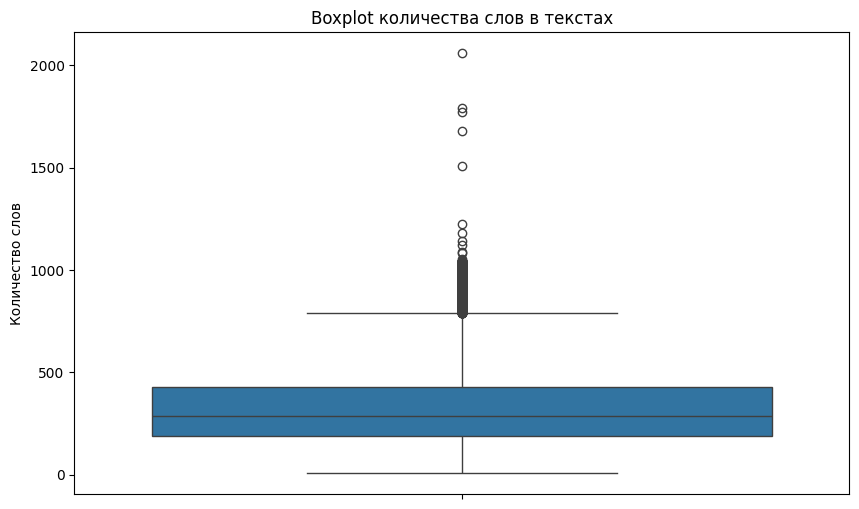

In [ ]:
df['word_count'] = df['text'].str.split().str.len()
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y='word_count')
plt.title('Boxplot количества слов в текстах')
plt.ylabel('Количество слов')
plt.show()

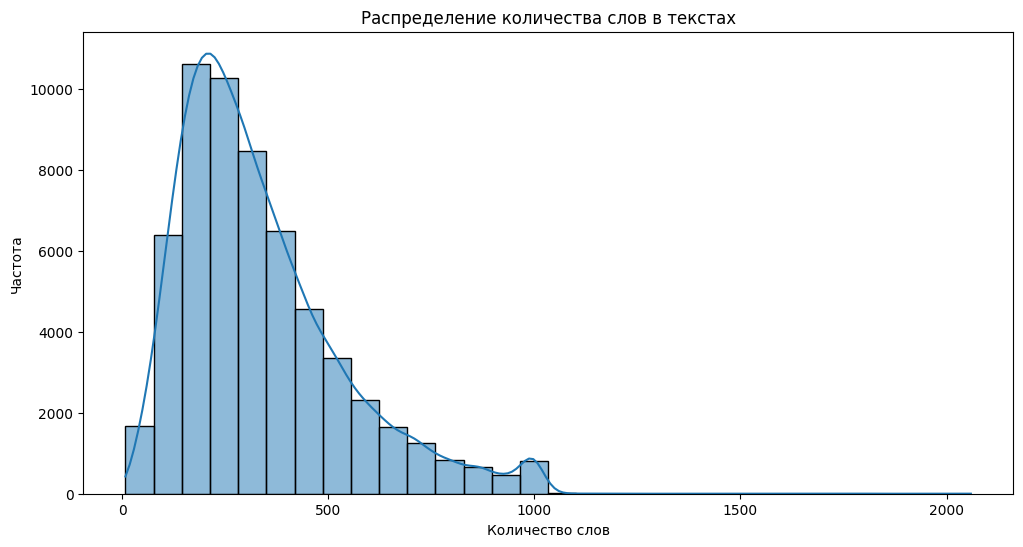

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='word_count', bins=30, kde=True)
plt.title('Распределение количества слов в текстах')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.show()

Для большего единообразия обучающей выборки удалим слишком длинные и слишком короткие тексты (более 700 и менее 50 слов)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'],
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

In [ ]:
mask_to_remove = (X_train.str.split().str.len() < 50) | (X_train.str.split().str.len() > 700)

X_train_cleaned = X_train[~mask_to_remove]
y_train_cleaned = y_train[~mask_to_remove]

print(f"Было записей: {len(X_train)}")
print(f"Осталось записей: {len(X_train_cleaned)}")

Было записей: 47828
Осталось записей: 44265


In [ ]:
X_train_cleaned.head()

,text
10401,джейсон стетхэм это уже массовая тенденция в и...
6161,в современном кинематографе не так уж и много ...
13012,сноуден биографическая драма о человеке открыв...
14475,странная вспыльчивая несчастная добрая милая с...
10138,в последнее время попадаю на женские боевики п...


# Классификация по 3 категориям

In [ ]:
!pip install tensorflow

In [ ]:
!pip install fasttext

Для векторизации используем готовую модель FastText.

In [ ]:
import fasttext
import fasttext.util

fasttext.util.download_model('ru', if_exists='ignore')
ft_model = fasttext.load_model("cc.ru.300.bin")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
import numpy as np
import random


# Фиксация seed

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_cleaned)
y_test_enc = le.transform(y_test)
num_classes = len(le.classes_)

X_train_cleaned = list(X_train_cleaned)
y_train_enc = np.array(y_train_enc)
X_test = list(X_test)
y_test_enc = np.array(y_test_enc)


embedding_dim = ft_model.get_word_vector("тест").shape[0]
max_len = 100
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class FastTextDataset(Dataset):
    def __init__(self, texts, labels, ft_model, max_len):
        self.texts = texts
        self.labels = labels
        self.ft_model = ft_model
        self.max_len = max_len
        self.embedding_dim = ft_model.get_word_vector("test").shape[0]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        X = np.zeros((self.max_len, self.embedding_dim), dtype=np.float32)
        words = text.split()
        for i, w in enumerate(words[:self.max_len]):
            X[i] = self.ft_model.get_word_vector(w)
        return torch.tensor(X), torch.tensor(label, dtype=torch.long)

train_dataset = FastTextDataset(X_train_cleaned, y_train_enc, ft_model, max_len)
test_dataset = FastTextDataset(X_test, y_test_enc, ft_model, max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Добавлена ранняя остановка

class EarlyStopping:
    def __init__(self, patience=3, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


# Модель CNN с AdaptiveMaxPool1d

class TextCNN(nn.Module):
    def __init__(self, embedding_dim, num_classes, dropout=0.1):
        super(TextCNN, self).__init__()
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=64, kernel_size=k)
            for k in [3, 4, 5]
        ])
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(64 * 3, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, emb_dim, seq_len)
        convs = [self.pool(self.relu(conv(x))).squeeze(-1) for conv in self.convs]
        out = torch.cat(convs, dim=1)
        out = self.dropout(self.relu(self.fc1(out)))
        return self.fc2(out)


# Модель BiLSTM с Attention

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim * 2, 1)

    def forward(self, lstm_output, mask):
        # lstm_output: (batch, seq_len, hidden_dim*2)
        attn_weights = self.attn(lstm_output).squeeze(-1)  # (batch, seq_len)
        attn_weights = attn_weights.masked_fill(~mask, -1e9)
        attn_weights = torch.softmax(attn_weights, dim=1)  # нормализация
        context = torch.bmm(attn_weights.unsqueeze(1), lstm_output).squeeze(1)
        return context, attn_weights

class BiLSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_classes, dropout=0.1):
        super(BiLSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=True
        )
        self.attention = Attention(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim * 2, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        with torch.no_grad():
            mask = (x.abs().sum(dim=2) != 0)
            lengths = mask.sum(dim=1).cpu()

        packed = nn.utils.rnn.pack_padded_sequence(
            x, lengths, batch_first=True, enforce_sorted=False
        )
        output_packed, _ = self.lstm(packed)
        output, _ = nn.utils.rnn.pad_packed_sequence(output_packed, batch_first=True)

        # Attention
        context, _ = self.attention(output, mask)
        out = self.dropout(torch.relu(self.fc1(context)))
        return self.fc2(out)


# Обучение модели

def train_model(model, train_loader, test_loader, epochs=10, lr=1e-3, patience=3):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for X_batch, y_batch in loop:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            preds = outputs.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
            total_loss += loss.item()

            loop.set_postfix(loss=loss.item())

        train_acc = correct / total
        avg_train_loss = total_loss / len(train_loader)

        # Валидация
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in tqdm(test_loader, desc="Validation", leave=False):
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                val_correct += (preds == y_batch).sum().item()
                val_total += y_batch.size(0)

        avg_val_loss = val_loss / len(test_loader)
        val_acc = val_correct / val_total
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break


# Тестирование модели

def evaluate_model(model, loader):
    model.eval()
    preds_all, y_all = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = outputs.argmax(dim=1).cpu().numpy()
            preds_all.extend(preds)
            y_all.extend(y_batch.numpy())

    acc = accuracy_score(y_all, preds_all)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_all, preds_all, average='weighted', zero_division=0
    )
    print(f"Accuracy: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")


# Обучение и тестирование CNN

cnn_model = TextCNN(embedding_dim, num_classes)
train_model(cnn_model, train_loader, test_loader, epochs=15, patience=4)
print("\n--- CNN Evaluation ---")
evaluate_model(cnn_model, test_loader)
print()


# Обучение и тестирование BiLSTM + Attention

bilstm_model = BiLSTMClassifier(embedding_dim, hidden_dim=64, num_classes=num_classes)
train_model(bilstm_model, train_loader, test_loader, epochs=15, patience=4)
print("\n--- BiLSTM + Attention Evaluation ---")
evaluate_model(bilstm_model, test_loader)

Epoch 1/15 [Train]: 100%|██████████| 1384/1384 [03:10<00:00,  7.28it/s, loss=1.04]


Epoch 1/15 | Train Loss: 1.0490 | Val Loss: 1.0045 | Val Acc: 0.4762


Epoch 2/15 [Train]: 100%|██████████| 1384/1384 [03:11<00:00,  7.24it/s, loss=0.701]


Epoch 2/15 | Train Loss: 0.9596 | Val Loss: 0.9653 | Val Acc: 0.5145


Epoch 3/15 [Train]: 100%|██████████| 1384/1384 [03:18<00:00,  6.96it/s, loss=1.04]


Epoch 3/15 | Train Loss: 0.9024 | Val Loss: 0.9608 | Val Acc: 0.5202


Epoch 4/15 [Train]: 100%|██████████| 1384/1384 [03:18<00:00,  6.97it/s, loss=1.14]


Epoch 4/15 | Train Loss: 0.8424 | Val Loss: 0.9683 | Val Acc: 0.5234


Epoch 5/15 [Train]: 100%|██████████| 1384/1384 [03:16<00:00,  7.04it/s, loss=0.837]


Epoch 5/15 | Train Loss: 0.7693 | Val Loss: 0.9835 | Val Acc: 0.5225


Epoch 6/15 [Train]: 100%|██████████| 1384/1384 [03:14<00:00,  7.11it/s, loss=0.871]


Epoch 6/15 | Train Loss: 0.6865 | Val Loss: 1.0845 | Val Acc: 0.5162


Epoch 7/15 [Train]: 100%|██████████| 1384/1384 [03:15<00:00,  7.08it/s, loss=0.688]


Epoch 7/15 | Train Loss: 0.6018 | Val Loss: 1.1665 | Val Acc: 0.5132
Early stopping triggered.

--- CNN Evaluation ---
Accuracy: 0.5132 | Precision: 0.5025 | Recall: 0.5132 | F1: 0.4972



Epoch 1/15 [Train]: 100%|██████████| 1384/1384 [09:06<00:00,  2.53it/s, loss=1.13]


Epoch 1/15 | Train Loss: 1.0171 | Val Loss: 0.9687 | Val Acc: 0.5115


Epoch 2/15 [Train]: 100%|██████████| 1384/1384 [09:09<00:00,  2.52it/s, loss=1]


Epoch 2/15 | Train Loss: 0.9444 | Val Loss: 0.9304 | Val Acc: 0.5417


Epoch 3/15 [Train]: 100%|██████████| 1384/1384 [08:46<00:00,  2.63it/s, loss=0.976]


Epoch 3/15 | Train Loss: 0.9134 | Val Loss: 0.9212 | Val Acc: 0.5484


Epoch 4/15 [Train]: 100%|██████████| 1384/1384 [08:38<00:00,  2.67it/s, loss=0.715]


Epoch 4/15 | Train Loss: 0.8931 | Val Loss: 0.9120 | Val Acc: 0.5534


Epoch 5/15 [Train]: 100%|██████████| 1384/1384 [08:58<00:00,  2.57it/s, loss=0.926]


Epoch 5/15 | Train Loss: 0.8750 | Val Loss: 0.9083 | Val Acc: 0.5578


Epoch 6/15 [Train]: 100%|██████████| 1384/1384 [09:05<00:00,  2.54it/s, loss=0.92]


Epoch 6/15 | Train Loss: 0.8581 | Val Loss: 0.9284 | Val Acc: 0.5480


Epoch 7/15 [Train]: 100%|██████████| 1384/1384 [09:19<00:00,  2.47it/s, loss=0.62]


Epoch 7/15 | Train Loss: 0.8426 | Val Loss: 0.9147 | Val Acc: 0.5535


Epoch 8/15 [Train]: 100%|██████████| 1384/1384 [09:14<00:00,  2.50it/s, loss=1.06]


Epoch 8/15 | Train Loss: 0.8231 | Val Loss: 0.9153 | Val Acc: 0.5555


Epoch 9/15 [Train]: 100%|██████████| 1384/1384 [09:14<00:00,  2.50it/s, loss=0.7]


Epoch 9/15 | Train Loss: 0.8040 | Val Loss: 0.9355 | Val Acc: 0.5462
Early stopping triggered.

--- BiLSTM + Attention Evaluation ---
Accuracy: 0.5462 | Precision: 0.5646 | Recall: 0.5462 | F1: 0.5513


Как и в случае базовых моделей, качество классификации на 3 класса довольно низкое. Попробуем выполнить бинарную классификацию, исключив нейтральный класс.

# Бинарная классификация

In [ ]:
labels = ['neg', 'pos']
df_binary = df[df['label'].isin(labels)]

df_binary['label'].value_counts()

,count
label,
pos,19999
neg,19803


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_binary['text'],
    df_binary['label'],
    test_size=0.2,
    random_state=42,
    stratify=df_binary["label"]
)

mask_to_remove = (X_train.str.split().str.len() < 50) | (X_train.str.split().str.len() > 700)

X_train_cleaned = X_train[~mask_to_remove]
y_train_cleaned = y_train[~mask_to_remove]

y_train_enc = le.fit_transform(y_train_cleaned)
y_test_enc = le.transform(y_test)
num_classes = len(le.classes_)

X_train_cleaned = list(X_train_cleaned)
y_train_enc = np.array(y_train_enc)
X_test = list(X_test)
y_test_enc = np.array(y_test_enc)

train_dataset = FastTextDataset(X_train_cleaned, y_train_enc, ft_model, max_len)
test_dataset = FastTextDataset(X_test, y_test_enc, ft_model, max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Обучение и тестирование CNN

cnn_model = TextCNN(embedding_dim, num_classes)
train_model(cnn_model, train_loader, test_loader, epochs=15, patience=4)
print("\n--- CNN Evaluation ---")
evaluate_model(cnn_model, test_loader)
print()


# Обучение и тестирование BiLSTM + Attention

bilstm_model = BiLSTMClassifier(embedding_dim, hidden_dim=64, num_classes=num_classes)
train_model(bilstm_model, train_loader, test_loader, epochs=15, patience=4)
print("\n--- BiLSTM + Attention Evaluation ---")
evaluate_model(bilstm_model, test_loader)

Epoch 1/15 [Train]: 100%|██████████| 922/922 [02:18<00:00,  6.66it/s, loss=0.533]


Epoch 1/15 | Train Loss: 0.6133 | Val Loss: 0.5420 | Val Acc: 0.7237


Epoch 2/15 [Train]: 100%|██████████| 922/922 [02:13<00:00,  6.90it/s, loss=0.74]


Epoch 2/15 | Train Loss: 0.4905 | Val Loss: 0.5081 | Val Acc: 0.7464


Epoch 3/15 [Train]: 100%|██████████| 922/922 [02:11<00:00,  7.01it/s, loss=0.637]


Epoch 3/15 | Train Loss: 0.4166 | Val Loss: 0.5524 | Val Acc: 0.7376


Epoch 4/15 [Train]: 100%|██████████| 922/922 [02:08<00:00,  7.16it/s, loss=0.226]


Epoch 4/15 | Train Loss: 0.3405 | Val Loss: 0.5304 | Val Acc: 0.7527


Epoch 5/15 [Train]: 100%|██████████| 922/922 [02:09<00:00,  7.13it/s, loss=0.418]


Epoch 5/15 | Train Loss: 0.2591 | Val Loss: 0.6057 | Val Acc: 0.7515


Epoch 6/15 [Train]: 100%|██████████| 922/922 [02:12<00:00,  6.96it/s, loss=0.151]


Epoch 6/15 | Train Loss: 0.1765 | Val Loss: 0.7282 | Val Acc: 0.7391
Early stopping triggered.

--- CNN Evaluation ---
Accuracy: 0.7391 | Precision: 0.7461 | Recall: 0.7391 | F1: 0.7371



Epoch 1/15 [Train]: 100%|██████████| 922/922 [06:10<00:00,  2.49it/s, loss=0.618]


Epoch 1/15 | Train Loss: 0.5861 | Val Loss: 0.5360 | Val Acc: 0.7288


Epoch 2/15 [Train]: 100%|██████████| 922/922 [05:47<00:00,  2.65it/s, loss=0.414]


Epoch 2/15 | Train Loss: 0.5082 | Val Loss: 0.4965 | Val Acc: 0.7579


Epoch 3/15 [Train]: 100%|██████████| 922/922 [06:00<00:00,  2.56it/s, loss=0.608]


Epoch 3/15 | Train Loss: 0.4776 | Val Loss: 0.4770 | Val Acc: 0.7686


Epoch 4/15 [Train]: 100%|██████████| 922/922 [05:43<00:00,  2.69it/s, loss=0.296]


Epoch 4/15 | Train Loss: 0.4560 | Val Loss: 0.4736 | Val Acc: 0.7719


Epoch 5/15 [Train]: 100%|██████████| 922/922 [05:43<00:00,  2.68it/s, loss=0.379]


Epoch 5/15 | Train Loss: 0.4369 | Val Loss: 0.4958 | Val Acc: 0.7581


Epoch 6/15 [Train]: 100%|██████████| 922/922 [05:53<00:00,  2.61it/s, loss=0.361]


Epoch 6/15 | Train Loss: 0.4219 | Val Loss: 0.4522 | Val Acc: 0.7851


Epoch 7/15 [Train]: 100%|██████████| 922/922 [05:44<00:00,  2.67it/s, loss=0.244]


Epoch 7/15 | Train Loss: 0.4091 | Val Loss: 0.4598 | Val Acc: 0.7814


Epoch 8/15 [Train]: 100%|██████████| 922/922 [05:50<00:00,  2.63it/s, loss=0.189]


Epoch 8/15 | Train Loss: 0.3944 | Val Loss: 0.4611 | Val Acc: 0.7882


Epoch 9/15 [Train]: 100%|██████████| 922/922 [05:45<00:00,  2.67it/s, loss=0.402]


Epoch 9/15 | Train Loss: 0.3809 | Val Loss: 0.4581 | Val Acc: 0.7875


Epoch 10/15 [Train]: 100%|██████████| 922/922 [05:38<00:00,  2.73it/s, loss=0.217]


Epoch 10/15 | Train Loss: 0.3641 | Val Loss: 0.4581 | Val Acc: 0.7865
Early stopping triggered.

--- BiLSTM + Attention Evaluation ---
Accuracy: 0.7865 | Precision: 0.7867 | Recall: 0.7865 | F1: 0.7864



--- CNN Evaluation ---
Accuracy: 0.7391
Macro-F1: 0.7369
Weighted-F1: 0.7371
ROC-AUC: 0.8260
PR-AUC: 0.8219

Confusion Matrix (test):
[[2581 1380]
 [ 697 3303]]


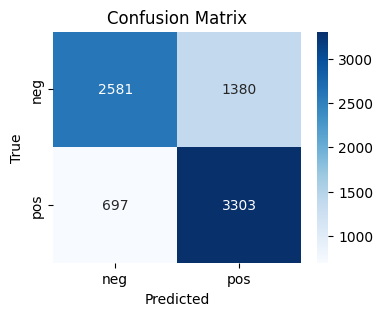



--- BiLSTM + Attention Evaluation ---
Accuracy: 0.7865
Macro-F1: 0.7864
Weighted-F1: 0.7864
ROC-AUC: 0.8735
PR-AUC: 0.8700

Confusion Matrix (test):
[[3044  917]
 [ 783 3217]]


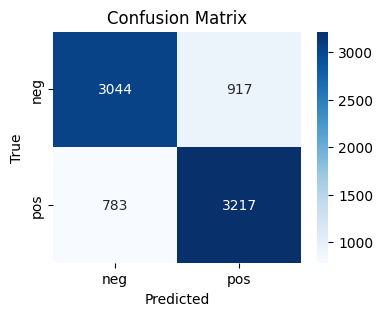

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_recall_fscore_support,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
)

def evaluate_model(model, loader):
    model.eval()
    preds_all, y_all = [], []
    probs_all = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # вероятности для pos класса
            preds = outputs.argmax(dim=1).cpu().numpy()

            probs_all.extend(probs)
            preds_all.extend(preds)
            y_all.extend(y_batch.numpy())

    # --- Метрики ---
    acc = accuracy_score(y_all, preds_all)
    f1_macro = f1_score(y_all, preds_all, average='macro')
    f1_weighted = f1_score(y_all, preds_all, average='weighted')

    try:
        roc_auc = roc_auc_score(y_all, probs_all)
        pr_auc = average_precision_score(y_all, probs_all)
    except ValueError:
        roc_auc = None
        pr_auc = None

    print(f"Accuracy: {acc:.4f}")
    print(f"Macro-F1: {f1_macro:.4f}")
    print(f"Weighted-F1: {f1_weighted:.4f}")
    if roc_auc is not None:
        print(f"ROC-AUC: {roc_auc:.4f}")
        print(f"PR-AUC: {pr_auc:.4f}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_all, preds_all)
    print("\nConfusion Matrix (test):")
    print(cm)

    # Визуализация матрицы ошибок
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


print("\n--- CNN Evaluation ---")
evaluate_model(cnn_model, test_loader)
print()
print("\n--- BiLSTM + Attention Evaluation ---")
evaluate_model(bilstm_model, test_loader)

При бинарной классификации метрики заметно выше, что подтверждает гипотезу о том, что нейтральный класс значительно усложняет задачу классификации. При этом полученные метрики все еще ниже метрик базовых моделей.